# <center>Đồ án 3: Linear Regression</center>

## Mục lục
- [Thông tin sinh viên](#c1)
- [Import](#c2)
- [Đọc dữ liệu](#c3)
- [Cài đặt hàm](#c4)
- [Yêu cầu 1: Phân tích khám phá dữ liệu](#c5)
  - [a) Understanding the Dataset](#c51)
  - [b) Data cleaning](#c52)
  - [c) Univariate Analysis](#c53)
  - [d) Bivariate Analysis](#c54)
  - [e) Multivariate Analysis](#c55)
- [Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp](#c61)
- [Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất](#c62)
- [Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất](#c63)

# Thông tin sinh viên <a class="anchor" id="c1"></a>

- Họ và tên: Nguyễn Hồ Đăng Duy
- MSSV: 22127085
- Lớp: 22CLC09

<a class="anchor" id="c2"></a>
# Import 

In [630]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Đọc dữ liệu <a class="anchor" id="c3"></a>

In [631]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm <a class="anchor" id="c4"></a>

In [632]:
# Cài đặt các hàm cần thiết ở đây
def preprocess(X):
    ''' 
    This function is used to preprocess the input data. It adds a column of ones to the input data.
    Ref: lab04
    
    Parameters
    ----------
    X : np.array
        Input data

    Returns
    -------
    np.hstack([np.ones((X.shape[0], 1)), X]) : np.array
        Preprocessed input data
    '''

    return np.hstack([np.ones((X.shape[0], 1)), X])

class OLSLinearRegression:
    def fit(self, X, y):
        ''' 
        This function is used to fit the model to the data. It uses the Ordinary Least Squares method to find the optimal parameters.
        Ref: lab04
        
        Parameters
        ----------
        X : np.array
            Input data
        y : np.array
            Output data

        Returns
        -------
        self : object
            Returns the instance of the class
        
        '''

        X_pinv = np.linalg.inv(X.T @ X) @ X.T    
        self.w = X_pinv @ y

        return self

    def get_params(self):
        ''' 
        This function is used to get the parameters of the model.
        Ref: lab04
        
        Returns
        -------
        self.w : np.array
            Optimal parameters (column vector)
        '''

        return np.round(self.w,3)

    def predict(self, X):
        ''' 
        This function is used to predict the output of the model.
        Ref: lab04
        
        Parameters
        ----------
        X : np.array
            Input data

        Returns
        -------
        X @ self.w : np.array
            Predicted output
        '''

        return X @ self.w

def mae(y, y_hat):
    ''' 
    This function is used to calculate the mean absolute error (MAE).

    Parameters
    ----------
    y : np.array
        Output data
    y_hat : np.array
        Predicted output data

    Returns
    -------
    np.mean(np.abs(y.ravel() - y_hat.ravel())) : float
        Mean absolute error
    '''

    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

def shuffle(data):
    ''' 
    This function is used to shuffle the data.
    Ref: lab04
    
    Parameters
    ----------
    data : np.array
        Input data

    Returns
    -------
    np.random.permutation(data) : np.array
        Shuffled data
    '''

    return np.random.permutation(data)


def k_fold_cross_validation(X, y, k=5):
    """
    Perform k-fold cross-validation using OLS and calculate MAE for each fold.

    Parameters:
    --------------------
    X (numpy array): The feature matrix.
    y (numpy array): The target vector.
    k (int): The number of folds (default is 5).

    Returns:
    --------------------
    float: Average Mean Absolute Error (MAE) across all folds.
    """
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    n_samples = len(y)
    fold_size = n_samples // k

    mae_scores = []

    for fold in range(k):
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        X_val = X[start_idx:end_idx]
        y_val = y[start_idx:end_idx]
        X_train = np.concatenate((X[:start_idx], X[end_idx:]))
        y_train = np.concatenate((y[:start_idx], y[end_idx:]))

        model = OLSLinearRegression()
        if np.linalg.matrix_rank(X_train) < X_train.shape[1]:
            continue
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mae_score = mae(y_val, predictions)
        mae_scores.append(mae_score)

    avg_mae = np.mean(mae_scores)
    return avg_mae


def choose_best_model(models, y):
    '''
    This function selects the best model based on the average MAE of k-fold cross-validation.

    PARAMETERS
    --------------------
    models: list
        List of feature matrices corresponding to each model.
    y: array-like, shape (n_samples,)
        The target values.

    RETURN
    --------------------
    int: The index of the best model based on the lowest average MAE.
    '''
    avg_mae_list = []
    for index, X in enumerate(models):
        avg_mae = k_fold_cross_validation(X, y, k=5)
        avg_mae_list.append(avg_mae)
        print(f"Model {index + 1} - Average MAE: {avg_mae:.3f}")

    best_model_index = np.argmin(avg_mae_list)
    return best_model_index


def forward_selection(X, y, num_features=5):
    '''
    Perform Forward Selection to choose the top features based on model performance.

    Parameters
    ----------
    X : np.array
        Input data (features).
    y : np.array
        Target variable.
    num_features : int
        Number of features to select.

    Returns
    -------
    list
        List of selected feature indices.
    '''
    num_total_features = X.shape[1]
    selected_features = []
    remaining_features = list(range(num_total_features))

    while len(selected_features) < num_features and remaining_features:
        mae_list = []
        for feature in remaining_features:
            features_subset = selected_features + [feature]
            X_subset = preprocess(X[:, features_subset])

            # Fit the model and calculate MAE
            model = OLSLinearRegression().fit(X_subset, y)
            predictions = model.predict(X_subset)
            mae_value = mae(y, predictions)
            mae_list.append(mae_value)

        best_feature = remaining_features[np.argmin(mae_list)]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features


def backward_elimination(X, y, num_features=5):
    '''
    Perform Backward Elimination to choose the top features based on model performance.

    Parameters
    ----------
    X : np.array
        Input data (features).
    y : np.array
        Target variable.
    num_features : int
        Number of features to select.

    Returns
    -------
    list
        List of selected feature indices.
    '''
    num_total_features = X.shape[1]
    selected_features = list(range(num_total_features))

    while len(selected_features) > num_features:
        mae_list = []
        for feature in selected_features:
            features_subset = [f for f in selected_features if f != feature]
            X_subset = preprocess(X[:, features_subset])

            # Fit the model and calculate MAE on the training set
            model = OLSLinearRegression().fit(X_subset, y)
            y_hat = model.predict(X_subset)
            mae_value = mae(y, y_hat)
            mae_list.append(mae_value)

        # Remove the feature whose removal minimizes the MAE
        best_feature_index = np.argmax(mae_list)
        selected_features.remove(selected_features[best_feature_index])

    return selected_features

*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu (1 điểm)  <a class="anchor" id="c5"></a>
Analyze the training dataset based on the structure of Exploratory Data Analysis (EDA)

In [633]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện

### a) Understanding the Dataset: <a class="anchor" id="c51"></a>
The dataset consists of 6 columns, 9000 rows in `train.csv`. These columns include:
- `Hours Studied`: Number of hours a student has studied.
- `Previous Scores`: Previous academic scores of the student.
- `Extracurricular Activities`: Binary indicator (0 or 1) of whether the student participated in extracurricular activities.
- `Sleep Hours`: Number of hours the student sleeps.
- `Sample Question Papers Practiced`: Number of sample question papers practiced by the student.
- `Performance Index`: A measure of the student's overall performance. The index ranges from 10 to 100, with higher values indicating better performance.
### b) Data cleaning: <a class="anchor" id="c52"></a>
- **Missing Values:** The dataset has no missing values as each column has 9000 non-null entries. 
- **Data Types**: 
  - `Extracurricular Activities` is correctly identified as a boolean 
  - The other columns are numeric, either integers (`Hours Studied`, `Previous Scores`, `Sleep Hours`, `Sample Question Papers Practiced`) or floats (`Performance Index`).

In [634]:
print("Dataset Overview:")
print(train.info())
print("\nFirst few rows of the dataset:")
print(train.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9000 non-null   int64  
 1   Previous Scores                   9000 non-null   int64  
 2   Extracurricular Activities        9000 non-null   int64  
 3   Sleep Hours                       9000 non-null   int64  
 4   Sample Question Papers Practiced  9000 non-null   int64  
 5   Performance Index                 9000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 422.0 KB
None

First few rows of the dataset:
   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               77                           0            5   
1              8               90                           1            4   
2              9               83                

### c) Univariate Analysis <a class="anchor" id="c53"></a>
1. **Histograms:** We would examine the distribution of numerical features (`Hours Studied`, `Previous Scores`, `Sleep Hours`, `Sample Question Papers Practiced`, `Performance Index`) to understand their spread, central tendencies, and any outliers.

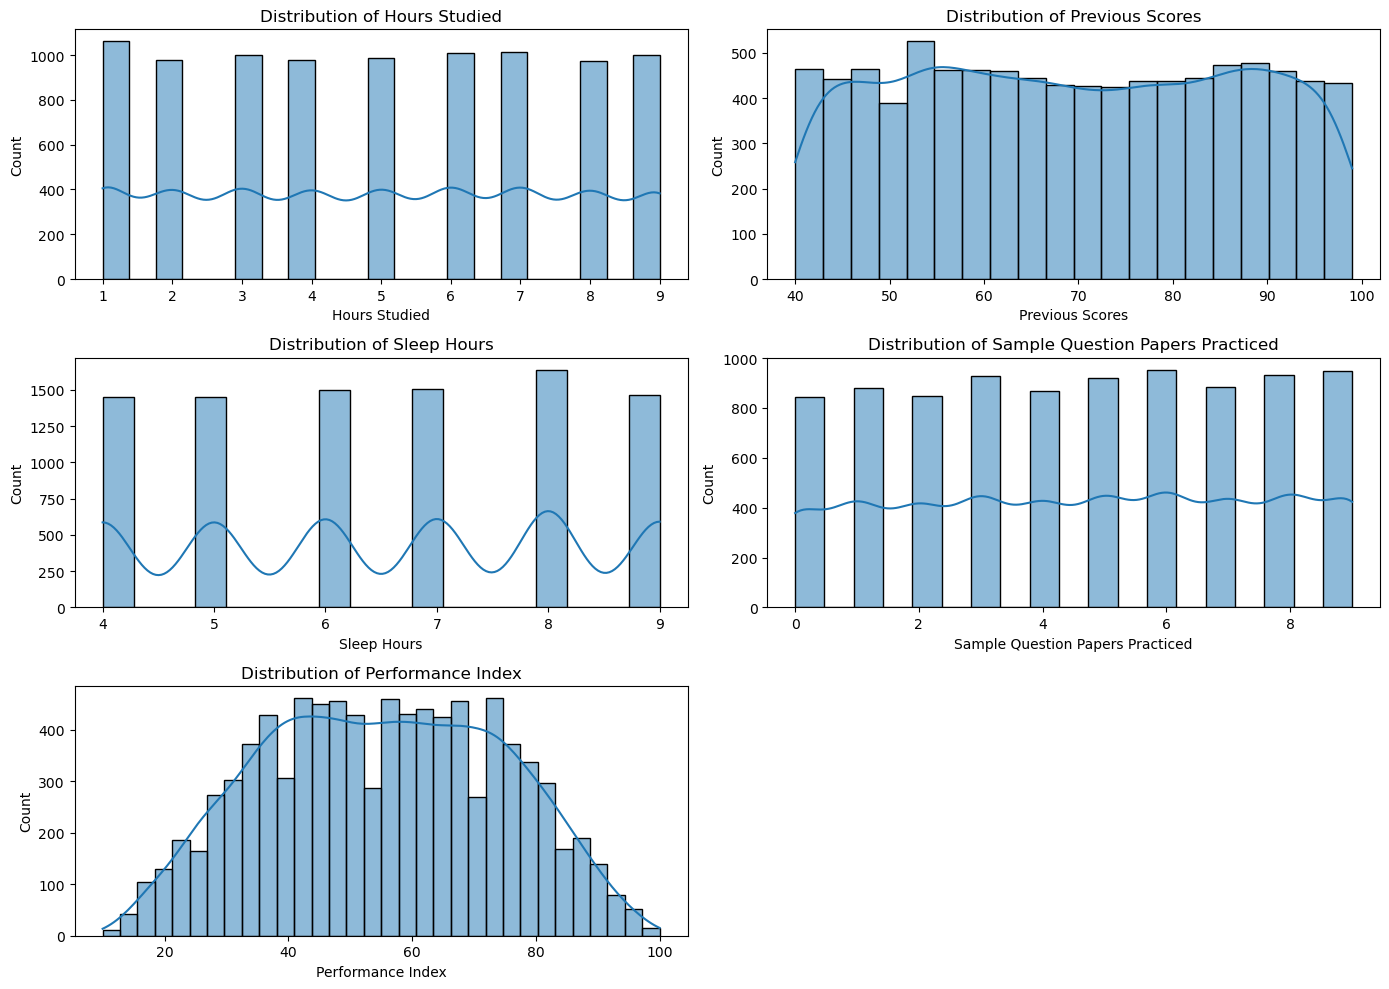

In [635]:
numerical_columns = ['Hours Studied', 'Previous Scores', 'Sleep Hours',
                     'Sample Question Papers Practiced', 'Performance Index']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- **Distribution of Hours Studied:** The distribution appears to be fairly uniform across different hours studied. Each hour interval from 1 to 9 has a similar number of students, with slightly more students studying for 1 hour.

- **Distribution of Previous Scores:** The distribution of previous scores is relatively even, with a slight concentration around the mid-range (50-60) and the higher end (90-100). This suggests that the student population has varied performance, with many scoring in the upper and middle ranges.

- **Distribution of Sleep Hours:** The number of students sleeping between 4 to 9 hours is almost uniformly distributed, with a slightly higher count at 8 hours. This could indicate that most students are getting a similar amount of sleep, with no particular preference for fewer or more sleep hours.

- **Distribution of Sample Question Papers Practiced:** Similar to hours studied, the number of sample question papers practiced is uniformly distributed. This suggests that students are practicing a similar number of sample papers, with no particular trend towards more or less practice.

- **Distribution of Performance Index:** The performance index follows a normal distribution, with a peak around the 60-70 range. This indicates that most students have an average performance, with fewer students scoring very low or very high. The distribution shows a slight right skew, meaning there are slightly more students with performance below the mean.
  

2. **Count Plot:** For `Extracurricular Activities`, a count plot will show how many students participated in activities versus those who didn't.

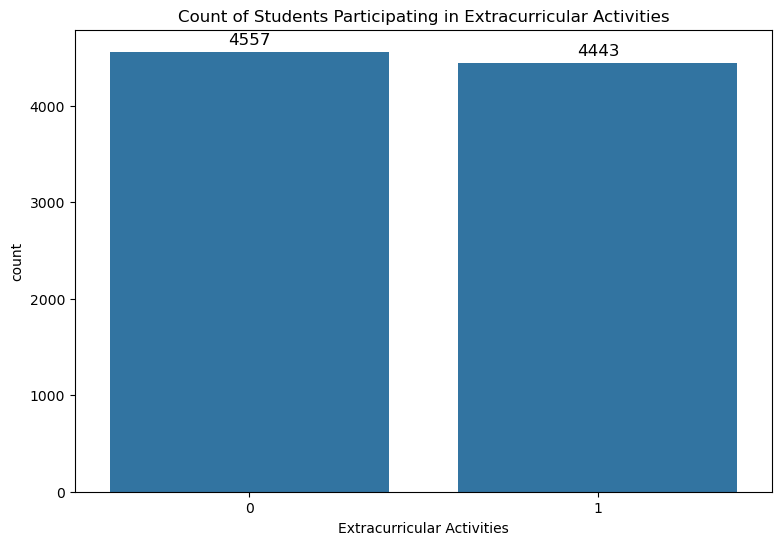

In [636]:
plt.figure(figsize=(9, 6))
ax = sns.countplot(x='Extracurricular Activities', data=train)
plt.title('Count of Students Participating in Extracurricular Activities')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.show()

- The number of students who do not participate in extracurricular activities (4557) is slightly higher than those who do participate (4443).
- The difference in participation is relatively small, indicating a near-even distribution between the two groups.
  


### d) Bivariate Analysis <a class="anchor" id="c54"></a>
1. **Correlation Matrix (Heatmap):** This visual representation helps in identifying the relationships between different features, especially focusing on how they correlate with `Performance Index`.

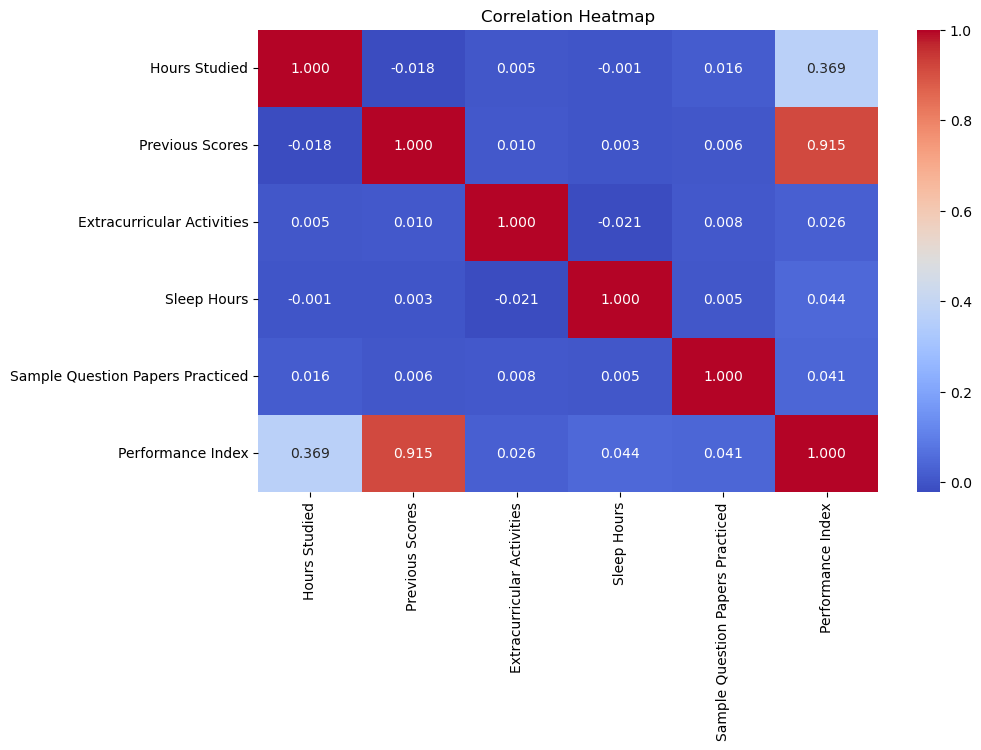

In [637]:
plt.figure(figsize=(10, 6))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
plt.show()

- **Strong Correlation:** There is a very strong positive correlation between `Previous Scores` and `Performance Index` (0.915). This suggests that students who have performed well in the past are likely to continue performing well.

- **Moderate Correlation:** Hours Studied shows a moderate positive correlation with `Performance Index` (0.369). This indicates that studying more hours generally leads to better performance, but other factors are also at play.

- **Weak or No Correlation:** The correlations between `Performance Index` and variables like `Extracurricular Activities` (0.026), `Sleep Hours` (0.044), and `Sample Question Papers Practiced` (0.041) are very weak, suggesting these factors have little to no impact on performance in this context.

- **Low Correlation:** There is almost no correlation between `Hours Studied` and `Previous Scores` (-0.018), implying that past academic performance doesn’t necessarily influence the number of hours a student decides to study.

- **Negligible Correlation:** The correlations among other variables, such as `Extracurricular Activities` with others, are close to zero, indicating minimal or no relationship.


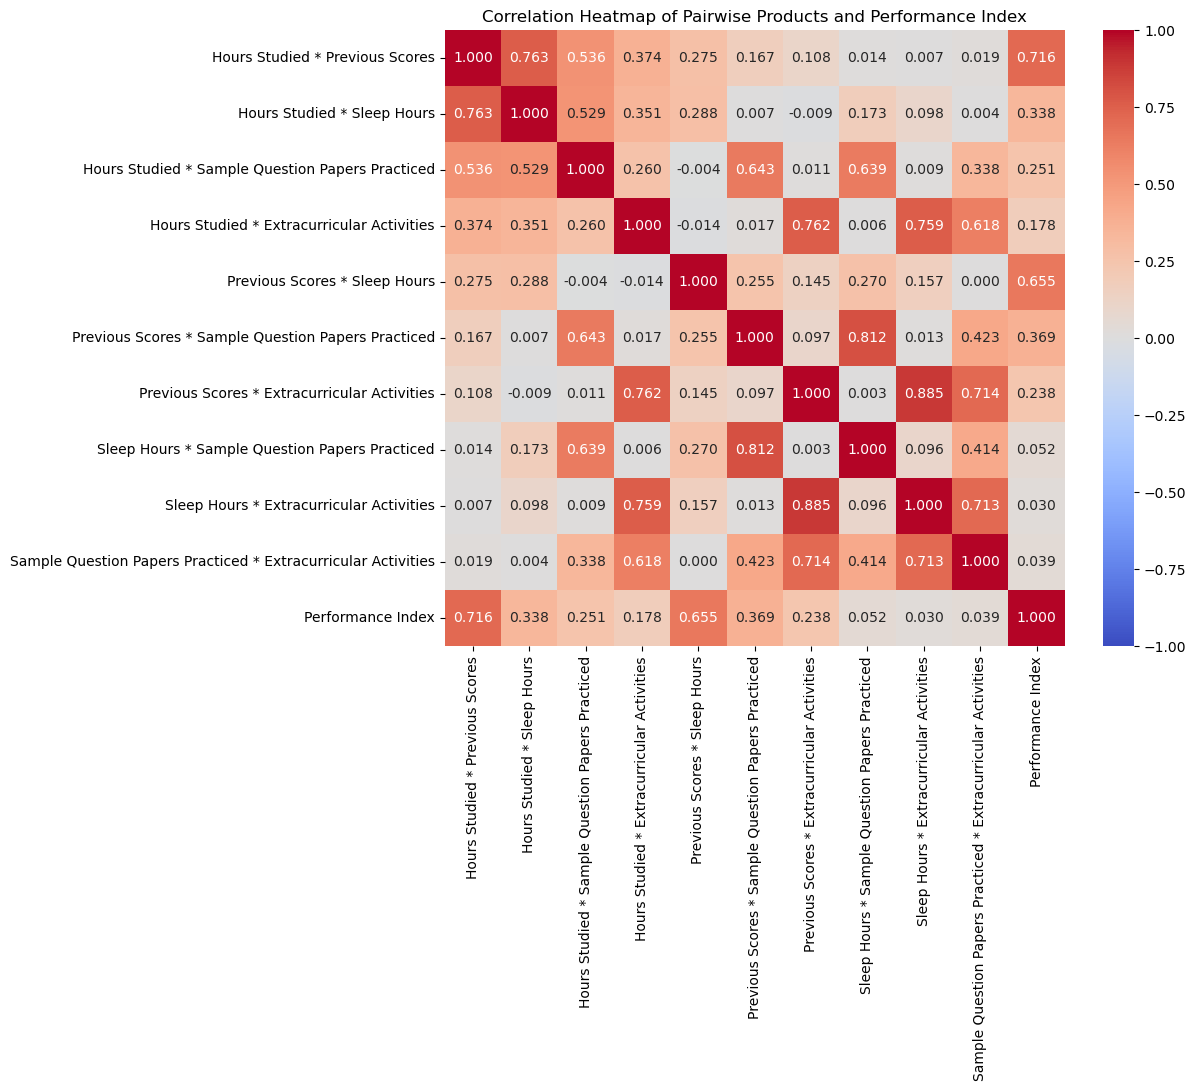

In [638]:
features = ['Hours Studied', 'Previous Scores', 'Sleep Hours',
            'Sample Question Papers Practiced', 'Extracurricular Activities']

# Create pairwise product features
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        feature_name = f'{features[i]} * {features[j]}'
        train[feature_name] = train[features[i]] * train[features[j]]

# Select only the pairwise product features and the target variable
product_features = [f'{features[i]} * {features[j]}' for i in range(
    len(features)) for j in range(i + 1, len(features))]
product_features.append('Performance Index')

# Compute the correlation matrix for the selected features
corr = train[product_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Pairwise Products and Performance Index')
plt.show()

This heatmap presents the correlation between various factors and the performance index, including pairwise products of certain variables. Here's a breakdown of the observations:
- `Hours Studied & Previous Scores` have a strong positive correlation (0.716) with the `Performance Index`. This suggests that students who studied more hours and had better previous scores performed better overall.
- `Hours Studied & Sample Question Papers Practiced` are highly correlated with each other (0.536) and also show a positive correlation with the `Performance Index` (0.338), indicating that practicing more sample papers while studying more leads to better performance.
- `Previous Scores & Sample Question Papers Practiced` have a moderately strong correlation (0.643), implying students who previously scored higher tend to practice more sample questions. Their combined impact on the Performance Index is also noticeable (0.369).
- `Previous Scores & Sleep Hours` and `Hours Studied & Sleep Hours` both have moderate correlations (0.275 and 0.288, respectively) with the `Performance Index`, suggesting that adequate sleep is somewhat important for performance but not as impactful as other variables.
- `Extracurricular Activities`: This factor shows weak to moderate correlation with other variables, including a low correlation with the `Performance Index` (0.039). However, it has a slightly stronger relationship with `Previous Scores` (0.762) and `Sleep Hours` (0.759), which indicates that students who are involved in extracurricular activities may have better previous scores and sleep patterns.
- The pairwise product of `Previous Scores and Extracurricular Activities` shows a fairly strong correlation with `Performance Index` (0.238), but `Extracurricular Activities` alone have minimal direct impact on the overall performance.

2. **Box Plots:**
- Box plots are used to visualize the distribution of data, highlighting the median, quartiles, and outliers. They are especially useful for comparing distributions across different groups or categories.
- Application in the Dataset:
  - `Sleep Hours` vs. `Performance Index`: Box plots help compare Performance Index across different `Sleep Hours`, showing how performance varies with sleep duration.
  - `Extracurricular Activities` vs. `Performance Index`: For the binary feature` Extracurricular Activities`, box plots easily compare performance between participants and non-participants.

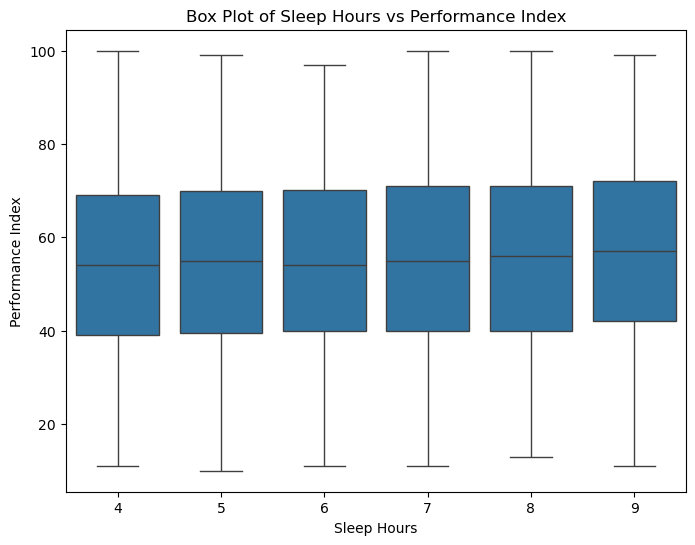

In [639]:
# Sleep Hours vs Performance Index
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sleep Hours', y='Performance Index', data=train)
plt.title('Box Plot of Sleep Hours vs Performance Index')
plt.xlabel('Sleep Hours')
plt.ylabel('Performance Index')
plt.show()

**First Box Plot (Sleep Hours vs Performance Index):**
- The median performance index remains consistent across different sleep hours (4 to 9 hours).
- The interquartile ranges (IQR) for all sleep hours are quite similar, indicating a similar distribution of performance regardless of the amount of sleep.
- There is no significant difference in the upper and lower whiskers across sleep hours, suggesting that the spread of performance index values is comparable.
- There are no apparent outliers in the data.        

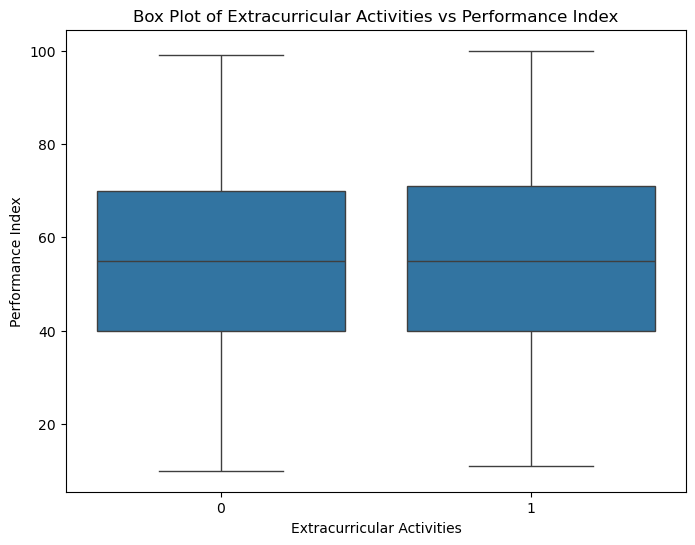

In [640]:
# Extracurricular Activities vs Performance Index
plt.figure(figsize=(8, 6))
sns.boxplot(x='Extracurricular Activities', y='Performance Index', data=train)
plt.title('Box Plot of Extracurricular Activities vs Performance Index')
plt.xlabel('Extracurricular Activities')
plt.ylabel('Performance Index')
plt.show()

**Second Box Plot (Extracurricular Activities vs Performance Index):**
- The median performance index is similar for both students who participate in extracurricular activities (1) and those who do not (0).
- The interquartile ranges (IQR) and whiskers are almost identical, indicating a similar distribution of performance in both groups.
- There are no noticeable outliers.
        

### e) Multivariate Analysis <a class="anchor" id="c55"></a>
The pair plot (also known as scatterplot matrix) visualizes the relationships between multiple numerical features in the dataset, allowing us to observe the distributions of individual variables and the pairwise relationships between them. Unlike correlation heatmaps, which represent correlation coefficients in a color-coded grid, pair plots depict the actual data points, revealing the nature of relationships beyond just their strength and direction. 

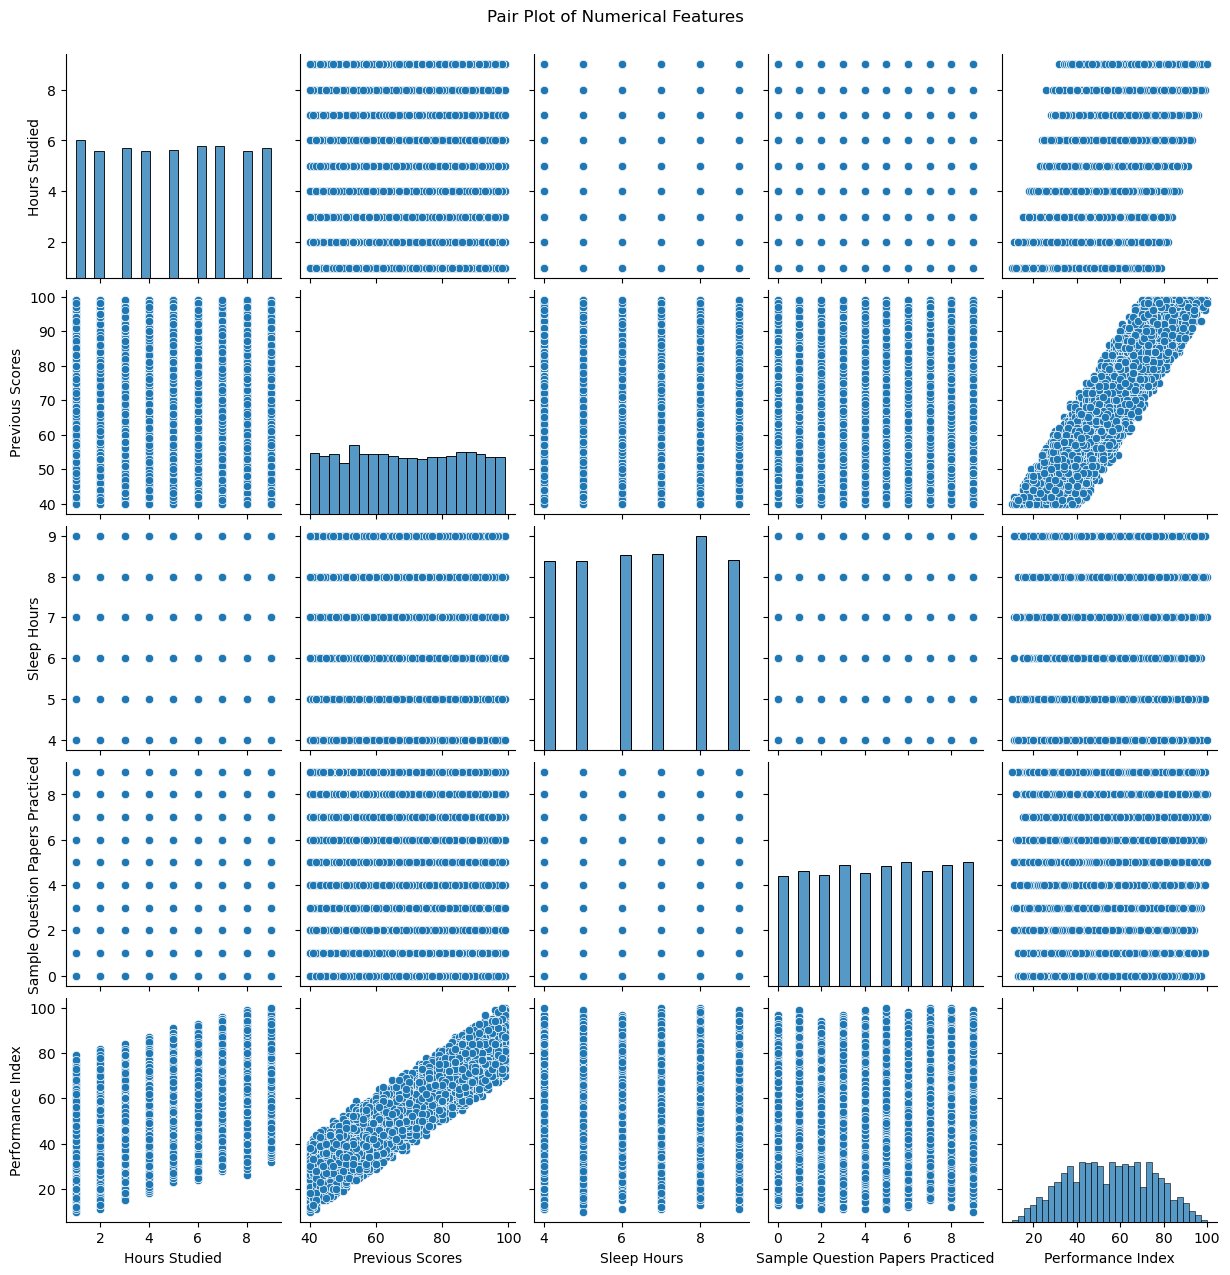

In [641]:
# Pair Plot
sns.pairplot(train[numerical_columns])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

1. **Diagonal Subplots (Distributions):** I have mentioned these diagrams in section **c1. Histograms:** 

2. **Hours Studied:** There is no noticeable pattern in the pair plots involving Hours Studied. The points are scattered, indicating weak or no linear relationship with other features like `Previous Scores` or `Performance Index`.

3. **Previous Scores:** There is a clear linear relationship between `Previous Scores` and `Performance Index`. The points cluster along a diagonal line, which supports the strong positive correlation observed earlier (0.915).

4. **Sleep Hours:** The points in the pair plots involving `Sleep Hours` appear uniformly spread out without forming any clear pattern. This suggests that sleep hours do not have a strong relationship with any of the other features, including the `Performance Index`.

5. **Sample Question Papers Practiced**: Similar to `Sleep Hours`, there is no obvious relationship between `Sample Question Papers Practiced` and other variables. The points in these plots are scattered without forming any distinct trend.

6. **Performance Index:**
- As noted, `Performance Index` shows a clear positive linear relationship with `Previous Scores`, indicating that students with higher past scores are more likely to have a higher performance index.
- No strong relationship is observed between the Performance Index and other variables, reinforcing the earlier findings.


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp (2 điểm) <a class="anchor" id="c61"></a>

In [642]:
# Phần code cho yêu cầu 2a
X_train_a = preprocess(X_train)
lr = OLSLinearRegression().fit(X_train_a, y_train)
W = lr.get_params()
print("W: ", W)

W:  [-33.969   2.852   1.018   0.604   0.474   0.192]


In [643]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
y_hat = lr.predict(X_train_a)
X_test_a = preprocess(X_test)
y_hat_test = lr.predict(X_test_a)
print("MAE 2a: ", mae(y_test, y_hat_test))

MAE 2a:  1.5956486884762917


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852* \textbf{Hours Studied} + 1.018*\textbf{Previous Scores} + 0.604*\textbf{Extracurricular Activities}\\ + 0.474*\textbf{Sleep Hours} + 0.192*\textbf{Sample Question Papers Practiced}$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất (2 điểm) <a class="anchor" id="c62"></a>

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [644]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu

avg_mae_list = []
X = np.array(X_train)
y = np.array(y_train)
models = []
for i in range(len(X_train.columns)):
    A = preprocess(X[:, i].reshape(-1, 1))
    models.append(A)
best_feature = choose_best_model(models, y)
print("The best feature model: ", X_train.columns[best_feature])

Model 1 - Average MAE: 15.451
Model 2 - Average MAE: 6.619
Model 3 - Average MAE: 16.195
Model 4 - Average MAE: 16.187
Model 5 - Average MAE: 16.185
The best feature model:  Previous Scores


### cross-validation result
<center>

| Index | Model with 1 feature 		    | MAE  |
|:---:|:-------------------------------:|:----:|
|  1  | Hours Studied			        |   15.451   |
|  2  | Previous Scores			        |   6.619   |
|  3  | Extracurricular Activities		|	16.195   |
|  4  | Sleep Hours						|	 16.187  |
|  5  | Sample Question Papers Practiced|    16.185  |

</center>


In [645]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_best_feature = np.array(X_train.iloc[:, best_feature])
X_train_best_feature.shape = (X_train_best_feature.shape[0], 1)
X_test_best_feature = np.array(X_test.iloc[:, best_feature])
X_test_best_feature.shape = (X_test_best_feature.shape[0], 1)

best_feature_model = OLSLinearRegression().fit(preprocess(X_train_best_feature), y_train)
W = best_feature_model.get_params()
print("W: ", W)

W:  [-14.989   1.011]


In [646]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
y_best_feature_hat = best_feature_model.predict(preprocess(X_test_best_feature))
print("MAE on test set with best feature model:", mae(y_test, y_best_feature_hat))


MAE on test set with best feature model: 6.5442772934525


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011*\textbf{Previous Scores}$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất (2 điểm) <a class="anchor" id="c63"></a>


Let: 
- $F_1$ = `Hours Studied`
- $F_2$ = `Previous Scores`
- $F_3$ = `Extracurricular Activities`
- $F_4$ = `Sleep Hours`
- $F_5$ = `Sample Question Papers Practiced`

## Xây dựng/Thiết kế mô hình

### Model 1
Based on the heatmap results, we can see that Previous Scores and Hours Studied have the most significant impact on the Performance Index. Therefore, we will build the model based on the sum of these two features.

$$\text{Student Performance} = \alpha_0 + \alpha_1 * F_1 + \alpha_2 * F_2$$


### Model 2
Based on the results of the Count Plot, the quantities of 0 and 1 for the feature Extracurricular Activities do not differ significantly. The weight of Extracurricular Activities compared to the Performance Index (in heatmap) is also very small (0.026), so we will exclude this feature from the model as it does not significantly impact the results. Meanwhile, Previous Scores has a very large weight (0.915), so we will apply a quadratic transformation to this feature, which has the highest impact.


$$\text{Student Performance} = \alpha_0 + \alpha_1 * F_1 + \alpha_2 * F_2 + \alpha_3 * F_4 + \alpha_4 * F_5 + \alpha_5 * F_2^2$$

### Model 3
Based on the pairwise heatmap, we will build a model to select the 5 best features using [forward selection](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_regression_forward_stepwise_regression_model.pdf).

$$\text{Student Performance} = \alpha_0 + \alpha_1 * F_2 + \alpha_2 * F_1 + \alpha_3 * (F_4*F_5) + \alpha_4 * F_4 + \alpha_5 * F_3$$

### Model 4
Based on the pairwise heatmap, we will build a model to select the 5 best features using [backward elimination](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_regression_backward_stepwise_elimination_regression_model.pdf).

$$\text{Student Performance} = \alpha_0 + \alpha_1 * F_3 + \alpha_2 * F_5 + \alpha_3 * (F_3*F_4) + \alpha_4 * (F_3*F_5) + \alpha_5 * (F_4 * F_5)$$


In [647]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình
# Features
F1 = train['Hours Studied'].values
F2 = train['Previous Scores'].values
F3 = train['Extracurricular Activities'].values
F4 = train['Sleep Hours'].values
F5 = train['Sample Question Papers Practiced'].values
y = train['Performance Index'].values

# Model 1: Linear Regression with F1 and F2
X_model_1 = np.column_stack((F1, F2))
print("Model 1 features: ['Hours Studied', 'Previous Scores']")

# Model 2: Linear Regression with F1, F2, F4, F5, and F2^2
F2_squared = F2 ** 2
X_model_2 = np.column_stack((F1, F2, F4, F5, F2_squared))
print("Model 2 features: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Previous Scores^2']")

# Generating all interaction terms for Model 3 and Model 4
features = [F1, F2, F3, F4, F5]
interaction_terms = []
feature_names = ['Hours Studied', 'Previous Scores',
                 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']

for (i, j) in combinations(range(5), 2):
    interaction_terms.append(features[i] * features[j])
    feature_names.append(f"{feature_names[i]}*{feature_names[j]}")

# Combine original features and interaction terms into one list
all_feature_names = feature_names[:5] + feature_names[5:]

# Model 3: Forward Selection to choose top 5 interaction terms
X_interactions = np.column_stack(features + interaction_terms)

selected_features_forward = forward_selection(
    X_interactions, y, num_features=5)
print("Model 3 selected features:", [
      all_feature_names[i] for i in selected_features_forward])
X_model_3 = X_interactions[:, selected_features_forward]

# Model 4: Backward Elimination to choose top 5 interaction terms
selected_features_backward = backward_elimination(
    X_interactions, y, num_features=5)
print("Model 4 selected features:", [
      all_feature_names[i] for i in selected_features_backward])
X_model_4 = X_interactions[:, selected_features_backward]


Model 1 features: ['Hours Studied', 'Previous Scores']
Model 2 features: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Previous Scores^2']
Model 3 selected features: ['Previous Scores', 'Hours Studied', 'Sleep Hours*Sample Question Papers Practiced', 'Sleep Hours', 'Extracurricular Activities']
Model 4 selected features: ['Extracurricular Activities', 'Sample Question Papers Practiced', 'Extracurricular Activities*Sleep Hours', 'Extracurricular Activities*Sample Question Papers Practiced', 'Sleep Hours*Sample Question Papers Practiced']


## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [648]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu
models = []
models.append(preprocess(X_model_1))
models.append(preprocess(X_model_2))
models.append(preprocess(X_model_3))
models.append(preprocess(X_model_4))

best_model_index = choose_best_model(models, y)
print("Best model index: ", best_model_index + 1)

Model 1 - Average MAE: 1.816
Model 2 - Average MAE: 1.641
Model 3 - Average MAE: 1.623
Model 4 - Average MAE: 16.192
Best model index:  3


### cross-validation result
<center>

| Index | Model 		    | MAE  |
|:---:|:-------------------------------:|:----:|
|  1  | Model 1			        |   1.816   |
|  2  | Model 2			        |  1.641    |
|  3  | Model 3		|	1.623   |
|  4  | Model 4					|	16.192   |

</center>


In [649]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
np.set_printoptions(precision=6, suppress=True)

X_2c = models[best_model_index]
my_best_model = OLSLinearRegression().fit(X_2c, y)
print("W: ", my_best_model.get_params())

W:  [-33.091   1.018   2.853   0.028   0.345   0.601]


In [650]:
# Bước 1: Chuẩn bị dữ liệu test
X_test = np.column_stack((test['Previous Scores'].values,
                          test['Hours Studied'].values,
                          test['Sleep Hours'] * test['Sample Question Papers Practiced'].values,
                          test['Sleep Hours'].values,
                        test['Extracurricular Activities'].values,
                          ))
y_test = test['Performance Index'].values

# Bước 2: Tiền xử lý dữ liệu test
X_test_processed = preprocess(X_test)

# Bước 3: Dự đoán bằng mô hình tốt nhất (Model 3)
# Huấn luyện mô hình 3
y_pred =my_best_model.predict(X_test_processed)  # Dự đoán trên dữ liệu test

# Bước 4: Tính MAE
mae_test = mae(y_test, y_pred)
print(f"Test MAE for Model 3: {mae_test}")

Test MAE for Model 3: 1.5957522096472956


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.091 + 1.018 * F_2 +2.853 * F_1 + 0.028 * (F_4*F_5) + 0.345 * F_4 + 0.601 * F_3$$